In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path  ='/content/drive/Shareddrives/데이터 청년 캠퍼스/젓가락질 데이터/새 젓가락질 데이터/excel 파일/vector/notcorrect1_vector.csv'

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import random
import seaborn as sns
sns.set(color_codes = True)
import matplotlib.pyplot as plt
%matplotlib inline


from numpy.random import seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import keras
import keras.callbacks as callabacks
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from sklearn import metrics
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_curve, auc

import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
data1 = pd.read_csv(path)

In [ ]:
data.shape

(97, 17)

In [4]:
normal_data_raw = pd.read_csv(path, skiprows = [0], nrows = 97, names = ['time', 'data'])

abnormal_data_raw = pd.read_csv(path, skiprows = [0], nrows = 97, names = ['time', 'data'])

normal_data_list = normal_data_raw['data'].values.tolist()
abnormal_data_list = abnormal_data_raw['data'].values.tolist()

In [5]:
normal_data_list = [list(map(float,x[2:-2].replace(" ","").split(","))) for x in normal_data_list]
abnormal_data_list = [list(map(float,x[2:-2].replace(" ","").split(","))) for x in abnormal_data_list]

In [6]:
normal_data_list = np.array(normal_data_list)
abnormal_data_list = np.array(abnormal_data_list)

In [7]:
normal_data_list.shape

(97, 3)

In [8]:
normal_data = np.array(normal_data_list).reshape(1, 97, 3)
normal_data_train = normal_data[:70]
normal_data_test = normal_data[70:]

abnormal_data = np.array(abnormal_data_list).reshape(1, 97, 3)
abnormal_data_test = abnormal_data[:27]


In [9]:
normal_data_test

array([], shape=(0, 97, 3), dtype=float64)

In [10]:
normal_data = np.array(normal_data_list).reshape(-1, 3)
normal_data_train = normal_data[:70]
normal_data_test = normal_data[70:]

abnormal_data = np.array(abnormal_data_list).reshape(-1, 3)
abnormal_data_test = abnormal_data[:27]

normal_test_tot = np.hstack((normal_data_test, np.zeros(normal_data_test.shape[0]).reshape(-1,1)))
abnormal_test_tot = np.hstack((abnormal_data_test, np.ones(abnormal_data_test.shape[0]).reshape(-1,1)))
test_tot = np.vstack((normal_test_tot, abnormal_test_tot))

In [11]:
test_tot[:,:-1][0]

array([ 0.03372997,  0.03633669, -0.01802202])

In [12]:
x_test, x_valid, y_test, y_valid = train_test_split(test_tot[: , :-1], test_tot[:, :-1], test_size = 0.3)

print(x_test.shape)
print(y_test.shape)
print(x_valid.shape)
print(y_valid.shape)

(37, 3)
(37, 3)
(17, 3)
(17, 3)


In [13]:
print(y_valid)

[[ 0.01137149  0.04597455  0.01423399]
 [ 0.00673676  0.06655693 -0.01379266]
 [ 0.0272662   0.01285946 -0.01240011]
 [ 0.00786316  0.04985905  0.00948329]
 [ 0.02543992  0.03630245 -0.00360376]
 [ 0.01246303  0.02616706 -0.02464142]
 [ 0.01391506  0.01056832 -0.0139605 ]
 [ 0.01115906  0.05195642  0.0044994 ]
 [ 0.01268452  0.0504725   0.01880478]
 [ 0.02524179  0.02422279 -0.01059969]
 [ 0.00900471  0.06089866 -0.0111091 ]
 [ 0.01126707  0.03306276  0.00419646]
 [ 0.01536649  0.05062753 -0.00078648]
 [ 0.00178546  0.05793113 -0.00277147]
 [ 0.01133293  0.05423659 -0.00136255]
 [ 0.00547564  0.05439281  0.00951562]
 [ 0.01056081  0.05601674  0.00993312]]


In [14]:

# 데이터 정규화 (0~1사이로 데이터를 정규화)
stder = StandardScaler()
stder.fit(normal_data_train)
x_normal_train_scaled = stder.transform(normal_data_train)
x_test_scaled = stder.transform(x_test)
x_valid_scaled = stder.transform(x_valid)

In [15]:
# LSTM 네트워크에 입력하기 위해 데이터 형태를 변형한다 -> [samples, timesteps, features]
x_normal_train_scaled = x_normal_train_scaled.reshape(x_normal_train_scaled.shape[0], 1, x_normal_train_scaled.shape[1])
x_test_scaled = x_test_scaled.reshape(x_test_scaled.shape[0], 1, x_test_scaled.shape[1])
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0], 1, x_valid_scaled.shape[1])

print('훈련 정상 데이터 스케일/차원 변경 결과 : ', x_normal_train_scaled.shape)
print('검증 데이터 스케일/차원 변경 결과 : ', x_valid_scaled.shape)
print('테스트 데이터 스케일/차원 변경 결과 : ', x_test_scaled.shape)

훈련 정상 데이터 스케일/차원 변경 결과 :  (70, 1, 3)
검증 데이터 스케일/차원 변경 결과 :  (17, 1, 3)
테스트 데이터 스케일/차원 변경 결과 :  (37, 1, 3)


In [16]:
# 오토인코더 신경망 구축 (신경망을 LSTM 레이어로 구축)
def autoencoder_model(X) :
  inputs = Input(shape = (X.shape[1], X.shape[2]))
  L1 = LSTM(140, activation = 'relu', return_sequences = True,
            kernel_regularizer = regularizers.l2(0.00))(inputs)
  L2 = LSTM(70, activation = 'relu', return_sequences = False)(L1)
  L3 = RepeatVector(X.shape[1])(L2)
  L4 = LSTM(70, activation = 'relu', return_sequences = True)(L3)
  L5 = LSTM(140, activation = 'relu', return_sequences = True)(L4)
  output = TimeDistributed(Dense(X.shape[2]))(L5)
  model = Model(inputs = inputs, outputs = output)
  return model

In [17]:
# 오토인코더 모델 생성
model = autoencoder_model(x_normal_train_scaled)
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 3)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 140)            80640     
_________________________________________________________________
lstm_1 (LSTM)                (None, 70)                59080     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 70)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 70)             39480     
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 140)            118160    
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 3)              423   

In [18]:
# 모델 학습 및 평가
nb_epochs = 20
batch_size = 5
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 5)]
history = model.fit(x_normal_train_scaled, x_normal_train_scaled, epochs = nb_epochs, batch_size = batch_size, callbacks = callbacks, validation_split = 0.04348).history

Epoch 1/20
14/14 [==============================] - 31s 163ms/step - loss: 1.0689 - val_loss: 0.8003
Epoch 2/20
14/14 [==============================] - 0s 10ms/step - loss: 1.0120 - val_loss: 0.7990
Epoch 3/20
14/14 [==============================] - 0s 9ms/step - loss: 1.0422 - val_loss: 0.7891
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 1.0472 - val_loss: 0.7537
Epoch 5/20
14/14 [==============================] - 0s 9ms/step - loss: 0.8268 - val_loss: 0.6166
Epoch 6/20
14/14 [==============================] - 0s 8ms/step - loss: 0.5174 - val_loss: 0.4516
Epoch 7/20
14/14 [==============================] - 0s 8ms/step - loss: 0.3717 - val_loss: 0.4983
Epoch 8/20
14/14 [==============================] - 0s 8ms/step - loss: 0.4690 - val_loss: 0.4744
Epoch 9/20
14/14 [==============================] - 0s 8ms/step - loss: 0.3658 - val_loss: 0.4539
Epoch 10/20
14/14 [==============================] - 0s 8ms/step - loss: 0.3769 - val_loss: 0.4377
Epoch 11/20
14/

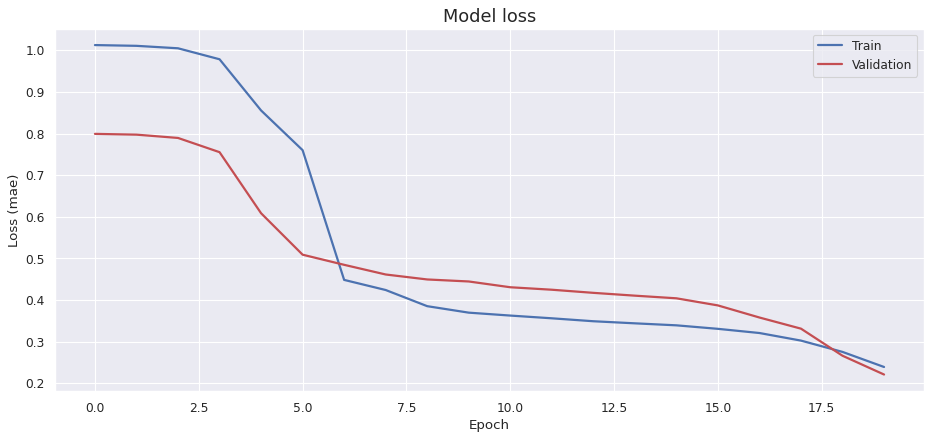

In [ ]:
# 학습 손실 시각화
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [ ]:
# 검증 데이터 입력 (결과 : 입력 데이터를 재구성한 결과)
predictions_3d = model.predict(x_valid_scaled)
predictions = predictions_3d.reshape(predictions_3d.shape[0], predictions_3d.shape[2])
x_valid_ = x_valid_scaled.reshape(x_valid_scaled.shape[0], x_valid_scaled.shape[2])

In [ ]:
# 재구성 손실 값 도출 (입력 데이터와 재구성 결과와의 차이)
mse = np.mean(np.power(x_valid_ - predictions, 2), axis = 1)

error_df = pd.DataFrame({'Reconstruction_error' : mse,
                         'True_class' : y_valid})

precision_rt, recall_rt, threshold_rt = metrics.precision_recall_curve(error_df['True_class'], error_df['Reconstruction_error'])

Exception: ignored

In [ ]:
# 모델 최적의 Threshold 값 찾기
best_cnt_dic = abs(precision_rt - recall_rt)
threshold_fixed = threshold_rt[np.argmin(best_cnt_dic)]
print('precision : ', precision_rt[np.argmin(best_cnt_dic)], ', recll : ', recall_rt[np.argmin(best_cnt_dic)])
print('threshold : ', threshold_fixed)

NameError: ignored

In [ ]:
plt.figure(figsize = (8, 5))
plt.plot(threshold_rt, precision_rt[1:], label = 'Precision')
plt.plot(threshold_rt, recall_rt[1:], label = 'Recall')
plt.xlabel('Threshold'); plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [ ]:
fpr, tpr, thresholds = roc_curve(y_valid, mse)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operationg Characteristic')
plt.plot(fpr, tpr, label = 'AUC = %0.4f' % roc_auc, linewidth = 5)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [ ]:
# 검증 데이터 입력 (결과 : 입력 데이터를 재구성한 결과)
test_predictions_3d = model.test_predict(x_test_scaled)
test_predictions = test_predictions_3d.reshape(test_predictions_3d.shape[0], test_predictions_3d.shape[2])
x_test_ = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[2])
mse = np.mean(np.power(x_test_ - test_predictions, 2), axis = 1)

error_df = pd.DataFrame({'Reconstruction_error' : mse,
                         'True_class' : y_test})

pred_y = [1 if e > threshold_fixed else 0 for e in error_df['Reconstruction_error'].values]
conf_matrix = metrics.confusion_matrix(error_df['True_class'], pred_y)

accuracy = (conf_matrix[0][0] + conf_matrix[1][1])/conf_matrix.sum()
print(accuracy)

sns.heatmap(conf_matrix, xticklabels = ['Normal', 'Break'], yticklabels = ['Normal', 'Break'], annot = True, fmt = 'd', annot_kws = {'size' : 10})
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class'); plt.ylabel('True Class')
plt.show()

In [ ]:
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups :
  ax.plot(group, index, group.Reconstruction_error, maker = 'o', ms = 3.5, linestyle = '',
          label = 'Break' if name == 1 else 'Normal')

ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors = 'r', zorder = 100, label = 'Threshold')
ax.legend()

plt.title('Reconstruction error for different classes')
plt.ylabel('Reconstruction error')
plt.xlabel('Data point index')
plt.show()